In [1]:
import numpy as np
import sympy as sp
from scipy.special import jn
from scipy.linalg import expm, logm
from scipy.integrate import quad
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib import cbook
import psutil
import time



# Pauli Z matrix
sigma_z = np.array([[1.0+0*1j, 0], [0, -1]])

# Identity matrix
I = np.eye(2)

def create_H0_mpo(N, g):
    """
    Creates the MPO for H0 = sum_i g_i sigma_i^z.

    Args:
        N (int): Number of qubits.
        g: Coefficients of g.

    Returns:
        list of np.ndarray: MPO tensors for H0.
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 3, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = 0
            tensor[0,1, :, :] = g * sigma_z
            tensor[0,2, :, :] = I
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((3, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[1,0, :, :] = g * sigma_z
            tensor[2,0, :, :] = 0
        else:
            # Middle tensors
            tensor = np.zeros((3, 3, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[1,0, :, :] = sigma_z
            tensor[2,1, :, :] = g * sigma_z
            tensor[2,2, :, :] = I
        mpo.append(tensor)
        
    return mpo



# Pauli X matrix
sigma_x = np.array([[0, 1.0], [1.0, 0]])

def create_Hc_mpo(N):
    """
    Creates the MPO for Hc = sum_i sigma_i^x.

    Args:
        N (int): Number of qubits.

    Returns:
        list of np.ndarray: MPO tensors for Hc.
    """
    
    mpo = []
    for i in range(N):

        if i == 0:
            # First tensor
            tensor = np.zeros((1, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
        elif i == N - 1:
            # Last tensor
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = sigma_x
            tensor[1,0, :, :] = I
        else:
            # Middle tensors
            tensor = np.zeros((2, 2, 2, 2), dtype=np.complex128)  # Bond dimension r=2
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_x
            tensor[1,1, :, :] = I
        mpo.append(tensor)
        
    return mpo



def create_I_mpo(N):

    mpo = []
    for i in range(N):
        tensor = np.zeros((1, 1, 2, 2), dtype=np.complex128)  # Bond dimension r=1
        tensor[0,0, :, :] = I
        mpo.append(tensor)

    return mpo



def add(mpo1,mpo2):

    assert len(mpo1) == len(mpo2)

    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]+mpo2[0].shape[1],2,2), dtype=np.complex128))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]+mpo2[i].shape[0],mpo1[i].shape[1]+mpo2[i].shape[1],2,2), dtype=np.complex128))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]+mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=np.complex128))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        new_mpo[0][0,j,:,:] = mpo1[0][0,j,:,:]
    for k in range(mpo2[0].shape[1]):
        new_mpo[0][0,mpo1[0].shape[1]+k,:,:] = mpo2[0][0,k,:,:]

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        new_mpo[len(mpo1)-1][j,0,:,:] = mpo1[len(mpo1)-1][j,0,:,:]
    for k in range(mpo2[len(mpo2)-1].shape[0]):
        new_mpo[len(mpo2)-1][mpo1[len(mpo1)-1].shape[0]+k,0,:,:] = mpo2[len(mpo2)-1][k,0,:,:]

    ## Now the tensors in the middle
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):
                    new_mpo[i][j,k,:,:] = mpo1[i][j,k,:,:]
    
            for j in range(mpo2[i].shape[0]):
                    for k in range(mpo2[i].shape[1]):
                        new_mpo[i][mpo1[i].shape[0]+j,mpo1[i].shape[1]+k,:,:] = mpo2[i][j,k,:,:]
    
    return new_mpo



def prod_scalar(mpo, c):
    new_mpo = [np.copy(tensor) for tensor in mpo]  # Make a deep copy
    for i in range(new_mpo[0].shape[0]):
        for j in range(new_mpo[0].shape[1]):
            for k in range(new_mpo[0].shape[2]):
                for l in range(new_mpo[0].shape[3]):
                    new_mpo[0][i, j, k, l] *= c
    return new_mpo


def prod(mpo1,mpo2):
    
    assert len(mpo1) == len(mpo2)

    new_mpo = []

    ## First we add the empty first boundary to the new list of core tensors
    new_mpo.append(np.zeros((1,mpo1[0].shape[1]*mpo2[0].shape[1],2,2), dtype=np.complex128))

    ## Add the rectangular tensors in the center
    if len(mpo1)>2:
        for i in range(1,len(mpo1)-1):
            new_mpo.append(np.zeros((mpo1[i].shape[0]*mpo2[i].shape[0],mpo1[i].shape[1]*mpo2[i].shape[1],2,2), dtype=np.complex128))

    ## Add the last ending boundary of the list of tensors
    new_mpo.append(np.zeros((mpo1[len(mpo1)-1].shape[0]*mpo2[len(mpo2)-1].shape[0],1,2,2), dtype=np.complex128))

    ## Compute the tensors for the boundaries
    for j in range(mpo1[0].shape[1]):
        for k in range(mpo2[0].shape[1]):
            new_mpo[0][0,k+j*(mpo2[0].shape[1]),:,:] = np.outer(mpo1[0][0,j,:,0],mpo2[0][0,k,0,:])+np.outer(mpo1[0][0,j,:,1],mpo2[0][0,k,1,:])

    for j in range(mpo1[len(mpo1)-1].shape[0]):
        for k in range(mpo2[len(mpo2)-1].shape[0]):
            new_mpo[len(mpo1)-1][k+j*(mpo2[len(mpo2)-1].shape[0]),0,:,:] = np.outer(mpo1[len(mpo1)-1][j,0,:,0],mpo2[len(mpo2)-1][k,0,0,:])+np.outer(mpo1[len(mpo1)-1][j,0,:,1],mpo2[len(mpo2)-1][k,0,1,:])


    ## Now we compute the values of the intermediate tensor cores
    if len(mpo1)>2:
        ## For each core tensor
        for i in range(1,len(mpo1)-1):
            ## Take each element of the first tensor
            for j in range(mpo1[i].shape[0]):
                for k in range(mpo1[i].shape[1]):

                    ## Compute with all the elements of the equivalent tensor in second mpo
                    for s in range(mpo2[i].shape[0]):
                        for t in range(mpo2[i].shape[1]):
                            new_mpo[i][s+j*(mpo2[i].shape[0]),t+k*(mpo2[i].shape[1]),:,:] = np.outer(mpo1[i][j,k,:,0],mpo2[i][s,t,0,:])+np.outer(mpo1[i][j,k,:,1],mpo2[i][s,t,1,:])

    return new_mpo


def contract(mpo):
    ## Create list for recursive multiplication of matrices, step by step
    mpo_contracted = []
    ## We define the first one as it's fixed
    mpo_contracted.append(mpo[0])
    for n in range(len(mpo)-1):
        ## For the first compression starting left to right we set an empty compressed tensor
        mpo_contracted.append(np.zeros((mpo[n].shape[0],mpo[n+1].shape[1],2**(n+2),2**(n+2)), dtype=np.complex128))
            
        for i in range(mpo[n+1].shape[1]):
            ## Now go over every element and take matrix multiplication with kronecker product
            mpo_comp = 0
            D_connect = mpo[n+1].shape[0]  # left bond of next tensor
            for j in range(D_connect):
                mpo_comp += np.kron(mpo_contracted[n][0,j,:,:], mpo[n+1][j,i,:,:])

                ## Add in the list to continue with the next compression
                (mpo_contracted[n+1])[0,i] = mpo_comp
                
    return mpo_contracted[len(mpo)-1][0][0]


def commutator(mpo1,mpo2):
    return add(prod(mpo1,mpo2),prod_scalar(prod(mpo2,mpo1),-1))



def commute(M1,M2):
    return (M1 @ M2) - (M2 @ M1) 


def reduce(mpo, bond_dimension):
    """
    Reduce the bond dimension of an MPO using SVD truncation.
    
    Args:
        mpo (list of np.ndarray): Input MPO tensors.
        bond_dimension (int): Target bond dimension after reduction.
        
    Returns:
        list of np.ndarray: Reduced MPO tensors.
    """
    new_mpo = []
    carry_over = None
    
    for i, tensor in enumerate(mpo):
        if carry_over is not None:
            # Merge the carry_over with current tensor
            # carry_over has shape (new_dleft, dright, phys_out)
            # tensor has shape (dleft, dright, phys_in, phys_out)
            # We need to contract carry_over with the left bond of the tensor
            tensor = np.einsum('mjk,ijkl->imkl', carry_over, tensor)
            
        # Original dimensions
        dleft, dright, phys_in, phys_out = tensor.shape
        
        # Combine left and physical dimensions
        matrix = tensor.transpose(0, 2, 1, 3).reshape(dleft * phys_in, dright * phys_out)
        
        # Perform SVD
        U, S, Vh = np.linalg.svd(matrix, full_matrices=False)
        
        # Truncate
        trunc = min(bond_dimension, len(S))
        U = U[:, :trunc]
        S = S[:trunc]
        Vh = Vh[:trunc, :]
        
        # Update bond dimension
        new_dright = trunc
        
        # Reshape U back to tensor
        new_tensor = U.reshape(dleft, phys_in, new_dright, -1).transpose(0, 2, 1, 3)
        new_mpo.append(new_tensor)
        
        # Prepare carry_over for next tensor (S * Vh)
        carry_over = np.diag(S) @ Vh
        carry_over = carry_over.reshape(new_dright, dright, phys_out)
    
    # Handle the last carry_over
    if carry_over is not None:
        # For the last tensor, reshape carry_over to match the expected shape
        # The last tensor should have shape (new_dright, 1, phys_out, 1)
        # Ensure the size of carry_over matches the target shape
        expected_size = new_dright * 1 * phys_out * 1
        if carry_over.size != expected_size:
            raise ValueError(f"Size mismatch: carry_over has size {carry_over.size}, but expected size is {expected_size}.")
        last_tensor = carry_over.reshape(new_dright, 1, phys_out, 1)
        new_mpo.append(last_tensor)
    
    return new_mpo


def Magnus_mpo(mpo_H0,mpo_Hc,u,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """

    ## Magnus series (order 2)

    a = -1j*quad(lambda x: 1,0,T)[0]
    b = -1j*quad(lambda x: u(x),0,T)[0]

    M1 = add(prod_scalar(mpo_H0,a),prod_scalar(mpo_Hc,b))
    """
    c = -1/2 * sp.integrate(sp.integrate(u(t2)-u(t1),(t2,0,t1)),(t1,0,T))

    M2 = prod_scalar(commutator(mpo_H0,mpo_Hc),c)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3)-2*u(t2)+u(t1),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1)*u(t3)-u(t1)*u(t2)-u(t2)*u(t3),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = add(prod_scalar(commutator(mpo_H0,commutator(mpo_H0,mpo_Hc)),d),prod_scalar(commutator(commutator(mpo_Hc,mpo_H0),mpo_Hc),e))
    
    M = add(M1,M2)"""

    return M1


def Magnus(H0,Hc,u,T):

    """
   First step to solve the time-dependent Schrödinger equation via Magnus expansion.

    Parameters:
    - mpo_H0: numpy array, static Hamiltonian as mpo
    - mpo_Hc: numpy array, control Hamiltonian as mpo
    - u: function u(t) defining time dependence
    - T: float, total evolution time

    Returns:
    - M: Magnus series
    """
    def commute(M1,M2):
        return (M1 @ M2) - (M2 @ M1)

    ## Magnus series (order 2)
    t1, t2, t3 = sp.symbols('t1 t2 t3')

    a = -1j*sp.integrate(1,(t1,0,T))
    b = -1j*sp.integrate(u(t1), (t1, 0, T)) 

    M1 = (a*H0) + (b*Hc)

    c = -1/2 * sp.integrate(sp.integrate(u(t2)-u(t1),(t2,0,t1)),(t1,0,T))

    M2 = c*commute(H0,Hc)

    d = 1j/6 * sp.integrate(sp.integrate(sp.integrate(u(t3)-2*u(t2)+u(t1),(t3,0,t2)),(t2,0,t1)),(t1,0,T))
    e = 1j/6 * sp.integrate(sp.integrate(sp.integrate(2*u(t1)*u(t3)-u(t1)*u(t2)-u(t2)*u(t3),(t3,0,t2)),(t2,0,t1)),(t1,0,T))

    M3 = d*(commute(H0,commute(H0,Hc))) + e*(commute(commute(Hc,H0),Hc))
    
    M = M1 + M2

    return M


def Chebyshev_mpo(mpo,N):
    """ 
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation
    """

    ##Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)+2*jn(4,1)
    b = 2*jn(1,1)+6*jn(3,1)
    c = 4*jn(2,1)+16*jn(4,1)
    d = 8*jn(3,1)
    e = 16*jn(4,1)

    C1 = prod_scalar(create_I_mpo(N),a)
    C2 = prod_scalar(mpo,b)
    C3 = prod_scalar(prod(mpo,mpo),c)
    C4 = prod_scalar(prod(prod(mpo,mpo),mpo),d)
    #C5 = prod_scalar(prod(prod(prod(mpo,mpo),mpo),mpo),e)

    C = add(add(add(C1,C2),C3),C4)

    
    return C

def Chebyshev(M,N):
    """ 
    Approximation of exponentiation of Magnus series to find the solution to the Schrödinger equation
    """

    ##Bessel function constants
    
    a = jn(0,1)+2*jn(2,1)
    b = 2*jn(1,1)
    c = 4*jn(2,1)

    C1 = a*np.eye(M.shape[0])
    C2 = b*M
    C3 = (c*M) @ M

    C = C1+C2

    
    return C


import qutip.settings
from scipy.sparse import csr_matrix
qutip.settings.auto_tidyup = False


def get_unitary(H0, Hc, u, T, timesteps=1000):
    """
    Solves the time-dependent Schrödinger equation and returns the unitary evolution matrix.

    Parameters:
    - H0: numpy array, static Hamiltonian
    - Hc: numpy array, control Hamiltonian
    - u: function u(t) defining time dependence
    - T: float, total evolution time
    - timesteps: int, number of time steps for integration

    Returns:
    - U_T: numpy array, final unitary matrix at time T
    """

    # Convert matrices to Qobj
    H0_q = qt.Qobj(H0, dims=[[H0.shape[0]], [H0.shape[1]]], isherm=True)
    Hc_q = qt.Qobj(Hc,  dims=[[H0.shape[0]], [H0.shape[1]]], isherm=True)
    
    # Time-dependent Hamiltonian
    H = [H0_q, [Hc_q, u]]

    # Initial state (identity operator for unitary evolution)
    identity = qt.qdiags([1] * H0.shape[0], 0)
    psi0 = identity

    # Time array
    tlist = np.linspace(0, T, timesteps)
    
    options = {"nsteps": 10000, "method": "bdf"}
    result = qt.sesolve(H, psi0, tlist, options=options)

    # Extract final unitary matrix
    U_T = result.states[-1].full()

    return U_T


def err_fidelity(U,V):

    ## Computes the fidelity error: 1-fidelity

    d = U.shape[0]  # Dimension of the unitary matrices
    fidelity = (np.abs(np.trace(np.conj(U.T) @ V)) / d) ** 2
    return np.abs(1 - fidelity)

In [2]:
def create_Ux_mpo(N, u, t):

    theta = u(t)*delta_t
    mpo = []
    for i in range(N):
        tensor = np.zeros((1, 1, 2, 2), dtype=np.complex128) 
        tensor[0,0, :, :] = np.array([[np.cos(theta), -1j*np.sin(theta)], [-1j*np.sin(theta), np.cos(theta)]])
        mpo.append(tensor)

    return mpo


def create_Uodd_mpo(N, g):
    """
    Creates the MPO for H0 = sum_i g_i sigma_i^z.

    Args:
        N (int): Number of qubits.
        g: Coefficients of g.

    Returns:
        list of MPO tensors.
    """
    theta = g*delta_t
    C = np.cos(theta)
    S = -1j*np.sin(theta)
    mpo = []
    for i in range(N-1):

        if i%2 == 0:
            tensor = np.zeros((1, 2, 2, 2), dtype=np.complex128)  
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_z

        else:
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  
            tensor[0,0, :, :] = C*I
            tensor[1,0, :, :] = S*sigma_z
            
        mpo.append(tensor)

    if (N-1) % 2 == 0:  
        tensor = np.zeros((1, 1, 2, 2), dtype=np.complex128)
        tensor[0, 0, :, :] = I
        mpo.append(tensor)

    else:
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  
            tensor[0,0, :, :] = C*I
            tensor[1,0, :, :] = S*sigma_z
            mpo.append(tensor)
        
    return mpo


def create_Ueven_mpo(N, g):
    """
    Creates the MPO for H0 = sum_i g_i sigma_i^z.

    Args:
        N (int): Number of qubits.
        g: Coefficients of g.

    Returns:
        list of MPO tensors.
    """
    theta = g*delta_t
    C = np.cos(theta)
    S = -1j*np.sin(theta)
    mpo = []

    tensor = np.zeros((1, 1, 2, 2), dtype=np.complex128)
    tensor[0,0, :, :] = I
    mpo.append(tensor)
    
    for i in range(N-2):

        if i%2 == 0:
            tensor = np.zeros((1, 2, 2, 2), dtype=np.complex128) 
            tensor[0,0, :, :] = I
            tensor[0,1, :, :] = sigma_z

        else:
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128) 
            tensor[0,0, :, :] = C*I
            tensor[1,0, :, :] = S*sigma_z
            
        mpo.append(tensor)

    if N % 2 == 0:  
        tensor = np.zeros((1, 1, 2, 2), dtype=np.complex128)
        tensor[0, 0, :, :] = I
        mpo.append(tensor)

    else:
            tensor = np.zeros((2, 1, 2, 2), dtype=np.complex128)  
            tensor[0,0, :, :] = C*I
            tensor[1,0, :, :] = S*sigma_z
            mpo.append(tensor)
        
    return mpo

In [3]:
from functools import reduce
import scipy

I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

def kronN(ops):
    """Kronecker product of a list of operators."""
    return reduce(np.kron, ops)

def Ux(L, theta_x):
    """Build U_X = exp(-i theta_x sum_j X_j)"""
    U_single = np.cos(theta_x)*I - 1j*np.sin(theta_x)*X
    return kronN([U_single]*L)

def two_site_U(theta_zz):
    """exp(-i theta_z Z⊗Z)."""
    ZZ = np.kron(Z, Z)
    return np.cos(theta_zz)*np.eye(4) - 1j*np.sin(theta_zz)*ZZ

def Uodd(L, theta_zz):
    """Build product of exp(-i theta_z Z_j Z_{j+1}) for odd j."""
    U = np.eye(2**L, dtype=complex)
    U2 = two_site_U(theta_zz)  

    for j in range(0, L-1, 2): 
        left = kronN([I]*j) if j > 0 else 1
        right = kronN([I]*(L - j - 2)) if j + 2 < L else 1

        U_local = np.kron(left, np.kron(U2, right))

        U = U_local @ U

    return U

def Ueven(L, theta_zz):
    """Build product of exp(-i theta_z Z_j Z_{j+1}) for even j."""
    U = np.eye(2**L, dtype=complex)
    U2 = two_site_U(theta_zz)
    for j in range(1, L-1, 2): 
        ops = [I]*L
        ops[j]   = None
        ops[j+1] = None
        left = kronN(ops[:j]) if j > 0 else 1
        right = kronN(ops[j+2:]) if j+2 < L else 1
        U_local = np.kron(left, np.kron(U2, right))
        U = U_local @ U
    return U

## Check numerics

In [4]:
N2 = 3
T = 1.0/N2
delta_t = T/N2

def u(t):
    return 1-t/T+(t/T)**2

mpo_0 = prod(create_Ux_mpo(N2,u,delta_t),prod(create_Uodd_mpo(N2,1),create_Ueven_mpo(N2,1)))

for k in range(2,N2+1):

    mpo_now = prod(create_Ux_mpo(N2,u,k*delta_t),prod(create_Uodd_mpo(N2,1),create_Ueven_mpo(N2,1)))
    mpo_0 = prod(mpo_now, mpo_0)

Udis_mpo = contract(mpo_0)

In [5]:
U_0 = Ux(N2,u(delta_t)*delta_t)@Uodd(N2,1*delta_t)@Ueven(N2,1*delta_t)

for k in range(2,N2+1):

    U_now = Ux(N2,u(k*delta_t)*delta_t)@Uodd(N2,1*delta_t)@Ueven(N2,1*delta_t)
    U_0 = U_now@U_0 
    
Udis = U_0

In [6]:
err_fidelity(Udis,Udis_mpo)

0.0

## Plots

In [4]:
K_max = 7
N1 = 9
g = 1
errs_dis = [[],[],[],[]]
errs_cont = []


def u(t):
    return 1-t/T+(t/T)**2

for K in range(4,K_max+1):

    for n in range(2,N1+1):

        T = 1.0/(2*n)
        delta_t = T/K
        
        mpo_0 = prod(create_Ux_mpo(n,u,delta_t),prod(create_Uodd_mpo(n,g),create_Ueven_mpo(n,g)))
    
        for k in range(2,K+1):
            mpo_now = prod(create_Ux_mpo(n,u,k*delta_t),prod(create_Uodd_mpo(n,g),create_Ueven_mpo(n,g)))
            mpo_0 = prod(mpo_now, mpo_0)

        U_dis = contract(mpo_0)

        H0 = contract(create_H0_mpo(n,g))
        Hc = contract(create_Hc_mpo(n))
        U_exact = get_unitary(H0,Hc,u, T)

        errs_dis[K-4].append(err_fidelity(U_exact, U_dis))


for n in range(2,N1+1):

    T = 1.0/(2*n)
    
    mpo1 = create_H0_mpo(n,g)
    mpo2 = create_Hc_mpo(n)
    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,n)
        
    U_cont = contract(U_computed)

    H0 = contract(create_H0_mpo(n,g))
    Hc = contract(create_Hc_mpo(n))
    U_exact = get_unitary(H0,Hc,u, T)

    errs_cont.append(err_fidelity(U_exact, U_cont))
    

C:\Users\llore\anaconda3\Lib\site-packages\qutip\solver\integrator\scipy_integrator.py:80: SparseEfficiencyWarning: Constructing a DIA matrix with 128 diagonals is inefficient
  state0 = _data.column_stack(state0)
C:\Users\llore\anaconda3\Lib\site-packages\qutip\solver\integrator\scipy_integrator.py:80: SparseEfficiencyWarning: Constructing a DIA matrix with 256 diagonals is inefficient
  state0 = _data.column_stack(state0)
C:\Users\llore\anaconda3\Lib\site-packages\qutip\solver\integrator\scipy_integrator.py:80: SparseEfficiencyWarning: Constructing a DIA matrix with 512 diagonals is inefficient
  state0 = _data.column_stack(state0)


C:\Users\llore\AppData\Local\Temp\ipykernel_16596\1791765956.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


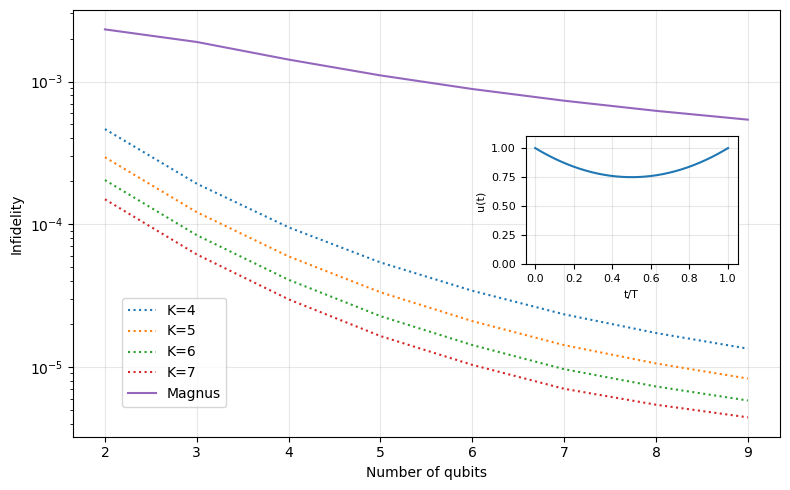

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = plt.cm.tab10.colors
x = np.arange(2, 10)


fig, ax = plt.subplots(figsize=(8,5))

for i, errs in enumerate(errs_dis):
    ax.plot(x, errs, linestyle=':', color=colors[i], label=f'K={i+4}')

ax.plot(x, errs_cont, linestyle='-', color=colors[len(errs_dis)], label='Magnus')

ax.set_xlabel("Number of qubits")
ax.set_ylabel("Infidelity")
ax.set_yscale("log")
ax.legend(loc='lower left', bbox_to_anchor=(0.07,0.07), borderaxespad=0.)
ax.grid(True, alpha=0.3)

T = 1.0
def u(t, T):
    return 1 - t/T + (t/T)**2

t_vals = np.linspace(0, T, 500)
u_vals = u(t_vals, T)

ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right',bbox_to_anchor=(-0.05, -0.28, 1, 1), bbox_transform=ax.transAxes)
ax_inset.plot(t_vals, u_vals)
ax_inset.set_xlabel("t/T", fontsize=8)
ax_inset.set_ylabel("u(t)", fontsize=8)
ax_inset.set_ylim(0.0,1.1)
ax_inset.grid(True, alpha=0.3)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()


plt.savefig("Trotter_poly2_1_with_inset_cheby3.png", dpi=300)
plt.show()

In [6]:
K_max = 7
N1 = 9
g = 1
errs_dis_2 = [[],[],[],[]]
errs_cont_2 = []

def u(t):
    return 1-t/T*3+(t/T)**2

for K in range(4,K_max+1):

    for n in range(2,N1+1):
        
        T = 1.0/(2*n)
        delta_t = T/K
        
        mpo_0 = prod(create_Ux_mpo(n,u,delta_t),prod(create_Uodd_mpo(n,g),create_Ueven_mpo(n,g)))
    
        for k in range(2,K+1):
            mpo_now = prod(create_Ux_mpo(n,u,k*delta_t),prod(create_Uodd_mpo(n,g),create_Ueven_mpo(n,g)))
            mpo_0 = prod(mpo_now, mpo_0)

        U_dis = contract(mpo_0)

        H0 = contract(create_H0_mpo(n,g))
        Hc = contract(create_Hc_mpo(n))
        U_exact = get_unitary(H0,Hc,u, T)

        errs_dis_2[K-4].append(err_fidelity(U_exact, U_dis))


for n in range(2,N1+1):

    T = 1.0/(2*n)
    
    mpo1 = create_H0_mpo(n,g)
    mpo2 = create_Hc_mpo(n)
    Mag = Magnus_mpo(mpo1,mpo2,u, T)
    U_computed = Chebyshev_mpo(Mag,n)
        
    U_cont = contract(U_computed)

    H0 = contract(create_H0_mpo(n,g))
    Hc = contract(create_Hc_mpo(n))
    U_exact = get_unitary(H0,Hc,u, T)

    errs_cont_2.append(err_fidelity(U_exact, U_cont))
    

C:\Users\llore\AppData\Local\Temp\ipykernel_16596\1240638285.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


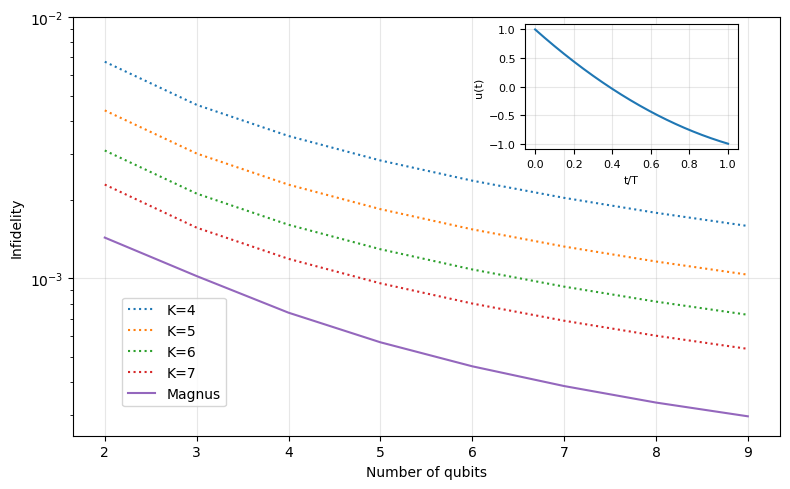

In [7]:
colors = plt.cm.tab10.colors

fig, ax = plt.subplots(figsize=(8,5))

for i, errs in enumerate(errs_dis_2):
    ax.plot(x, errs, linestyle=':', color=colors[i], label=f'K={i+4}')

ax.plot(x, errs_cont_2, linestyle='-', color=colors[len(errs_dis)], label='Magnus')

ax.set_xlabel("Number of qubits")
ax.set_ylabel("Infidelity")
ax.set_yscale("log")
ax.set_ylim(2.5*1e-4, 1e-2)
ax.legend(loc='lower left', bbox_to_anchor=(0.07,0.07), borderaxespad=0.)
ax.grid(True, alpha=0.3)


T = 1.0
def u(t, T):
    return 1 - 3*t/T + (t/T)**2

t_vals = np.linspace(0, T, 500)
u_vals = u(t_vals, T)

ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right',bbox_to_anchor=(-0.05, 0, 1, 1), bbox_transform=ax.transAxes)
ax_inset.plot(t_vals, u_vals)
ax_inset.set_xlabel("t/T", fontsize=8)
ax_inset.set_ylabel("u(t)", fontsize=8)
ax_inset.set_ylim(-1.1, 1.1)
ax_inset.grid(True, alpha=0.3)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()


plt.savefig("Trotter_poly2_3_with_inset_cheby3.png", dpi=300)
plt.show()

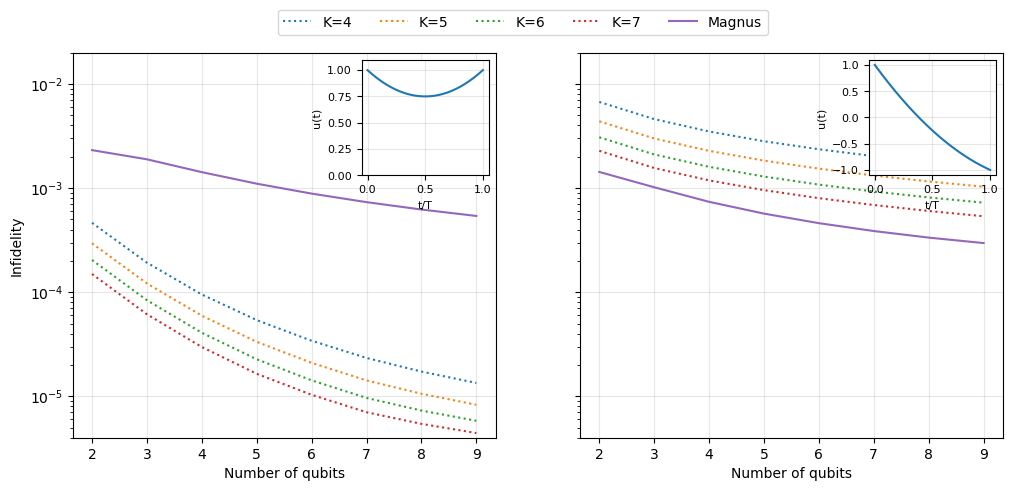

In [8]:
colors = plt.cm.tab10.colors

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, errs in enumerate(errs_dis):
    ax1.plot(x, errs, linestyle=':', color=colors[i], label=f'K={i+4}')

ax1.plot(x, errs_cont, linestyle='-', color=colors[len(errs_dis)], label='Magnus')

ax1.set_xlabel("Number of qubits")
ax1.set_ylabel("Infidelity")
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3)

T = 1.0
def u1(t, T):
    return 1 - t/T + (t/T)**2

t_vals = np.linspace(0, T, 500)
ax_inset1 = inset_axes(ax1, width="30%", height="30%", loc='upper right')
ax_inset1.plot(t_vals, u1(t_vals, T))
ax_inset1.set_xlabel("t/T", fontsize=8)
ax_inset1.set_ylabel("u(t)", fontsize=8)
ax_inset1.set_ylim(0.0, 1.1)
ax_inset1.grid(True, alpha=0.3)
ax_inset1.tick_params(axis='both', which='major', labelsize=8)

for i, errs in enumerate(errs_dis_2):
    ax2.plot(x, errs, linestyle=':', color=colors[i], label=f'K={i+4}')

ax2.plot(x, errs_cont_2, linestyle='-', color=colors[len(errs_dis)], label='Magnus')

ax2.set_xlabel("Number of qubits")
ax2.set_yscale("log")
ax2.set_ylim(4e-6, 2e-2)
ax2.grid(True, alpha=0.3)

def u2(t, T):
    return 1 - 3*t/T + (t/T)**2

ax_inset2 = inset_axes(ax2, width="30%", height="30%", loc='upper right')
ax_inset2.plot(t_vals, u2(t_vals, T))
ax_inset2.set_xlabel("t/T", fontsize=8)
ax_inset2.set_ylabel("u(t)", fontsize=8)
ax_inset2.set_ylim(-1.1, 1.1)
ax_inset2.grid(True, alpha=0.3)
ax_inset2.tick_params(axis='both', which='major', labelsize=8)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',bbox_to_anchor=(0, -0.02, 1, 1),  ncol=len(labels), frameon=True, fontsize=10)


plt.savefig("Trotter_combined.png", dpi=300)
plt.show()